In [422]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [423]:
import torch
import matplotlib.pyplot as plt
from vae import VAE
from tqdm import tqdm

import torchvision
import torchvision.datasets as datasets
import os
import random
from PIL import Image
from utils import train_model, image_view

torch.set_default_dtype(torch.float64)

In [424]:
dataset_name = 'mnist'  # choose which one to use here

dataset_names = ['mnist', 'celeba', 'celeba64x64']
dataset_info = {}
dataset_info['mnist'] = {
    'image_dims': (28, 28),
    'colour_channels': 1,
}
dataset_info['celeba'] = {
    'image_dims': (178, 218),
    'colour_channels': 3,
}
dataset_info['celeba64x64'] = {
    'image_dims': (64, 64),
    'colour_channels': 3,
}

In [425]:
if dataset_name == 'mnist':

    mnist = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor(),
    )
    mnist_iter = iter(torch.utils.data.DataLoader(mnist, shuffle=True))
    
    num_train = 60_000  # note cannot be greater than 60_000 for MNIST
    binary_pixels = False

    training_images = []
    for _ in tqdm(range(num_train)):
        img = next(mnist_iter)[0].squeeze(0).permute(1, 2, 0) # swap 'mnist_iter' for 'celeba_iter'
        if binary_pixels:
            img = img.round()
        training_images.append(img)
    
elif dataset_name == 'celeba':

    celeba = datasets.CelebA(
        root='./data',
        split='train',
        download=True,
        transform=torchvision.transforms.ToTensor(),
    )
    celeba_iter = iter(torch.utils.data.DataLoader(celeba, shuffle=True))

    num_train = 60_000  

    training_images = []
    for _ in tqdm(range(num_train)):
        img = next(celeba_iter)[0].squeeze(0).permute(1, 2, 0) # swap 'mnist_iter' for 'celeba_iter'
        training_images.append(img)
        
elif dataset_name == 'celeba64x64':

    num_train = 40_000

    celeba_dir = "./data/celeba64x64"
    img_file_paths = [
        os.path.join(celeba_dir, f) for f in os.listdir(celeba_dir) if f.endswith(".jpg")
    ]
    random.shuffle(img_file_paths)

    train_paths = img_file_paths[:num_train]
    transform = torchvision.transforms.ToTensor()

    training_images = []
    for file_path in tqdm(train_paths):
        img = transform(Image.open(file_path)).permute(1, 2, 0)
        training_images.append(img)
        
else:
    print("Dataset not found. Ensure dataset name is correct.")

  0%|          | 0/60000 [00:00<?, ?it/s]

100%|██████████| 60000/60000 [00:10<00:00, 5658.53it/s]


In [426]:
latent_dim = 32

vae_model = VAE(
    image_dims = dataset_info[dataset_name]['image_dims'],
    colour_channels = dataset_info[dataset_name]['colour_channels'],
    latent_dim = latent_dim,
    enc_architecture = 'cnn',
    # enc_mlp_hidden_dims = [64],
    enc_cnn_chans=[1, 32, 32, 32],  # make sure to change colour chans here
    dec_architecture = 'cnn',
    dec_cnn_chans=[32, 32, 32, 1],
    # dec_mlp_hidden_dims = [64],
    kernel_size=5,
    noise = 'imagewise-heteroscedastic',  # make sure 'beta_nll' is set to True in cell below if using pixelwise-hetero
    train_noise=True,
    noise_std=0.1,
    likelihood_activation=torch.nn.Sigmoid(),
    posterior_form='full_covariance_gaussian',
    likelihood='gaussian',
)

print(vae_model)

VAE(
  (nonlinearity): ReLU()
  (posterior): FullCovarianceGaussian()
  (likelihood): GaussianLikelihood(
    (activation): Sigmoid()
  )
  (encoder): Encoder(
    (nonlinearity): ReLU()
    (posterior): FullCovarianceGaussian()
    (network): EncodingCNN(
      (net): Sequential(
        (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 1056, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
        (5): AdaptiveAvgPool2d(output_size=(1, 1))
      )
    )
  )
  (decoder): Decoder(
    (nonlinearity): ReLU()
    (likelihood): GaussianLikelihood(
      (activation): Sigmoid()
    )
    (network): DecodingCNN(
      (net): Sequential(
        (0): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
        (1): ReLU()
        (2): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))

In [427]:
tracker = train_model(
    vae_model,
    training_images,
    batch_size=5,
    lr=5e-4,
    max_epochs=10_000,
    min_es_iters=500,
    early_stopping=False,
    beta_nll=False,
    beta=0.5,
    )

Constructing training batches...


  0%|          | 0/12000 [00:00<?, ?it/s]

100%|██████████| 12000/12000 [00:01<00:00, 8913.81it/s]


Executing training loop...


epochs: 100%|██████████| 10000/10000 [05:05<00:00, 32.70it/s, elbo=607, ll=654, kl=47.4, RMSE=0.117]    


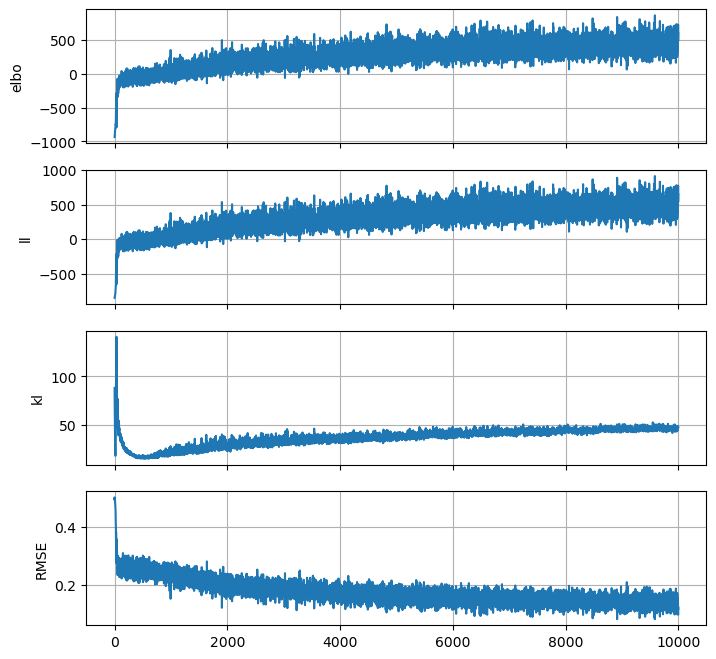

In [428]:
fig, axes = plt.subplots(
    len(tracker.keys()),
    1,
    figsize=(8, len(tracker.keys()) * 2),
    dpi=100,
    sharex=True,
)

for ax, (key, vals) in zip(axes, tracker.items()):
    ax.plot(vals)
    ax.set_ylabel(key)
    ax.grid()

plt.show()

In [429]:
torch.manual_seed(0)

num_test = 5

if dataset_name == 'mnist':
    
    mnist_test = datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor(),
    )
    mnist_test_iter = iter(torch.utils.data.DataLoader(mnist_test, shuffle=False))

    test_images = []
    for _ in range(num_test):
        img = next(mnist_test_iter)[0].squeeze(0).permute(1, 2, 0)
        if binary_pixels:
            img = img.round()
        test_images.append(img.unsqueeze(0))
        
        
elif dataset_name == 'celeba':
    
    celeba_test = datasets.CelebA(
        root='./data',
        split='test',
        download=True,
        transform=torchvision.transforms.ToTensor(),
    )
    celeba_test_iter = iter(torch.utils.data.DataLoader(celeba_test, shuffle=False))

    test_images = []
    for _ in range(num_test):
        img = next(celeba_test_iter)[0].squeeze(0).permute(1, 2, 0)
        test_images.append(img.unsqueeze(0))
    

elif dataset_name == 'celeba64x64':
    
    test_paths = img_file_paths[num_train : num_train + num_test]
    test_images = []
    for file_path in test_paths:
        img = transform(Image.open(file_path)).permute(1, 2, 0)
        test_images.append(img.unsqueeze(0))

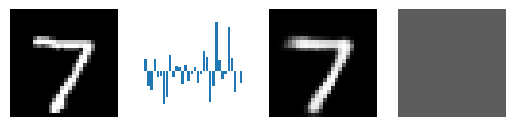

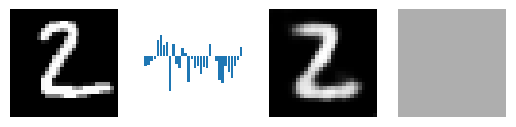

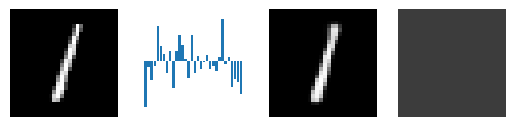

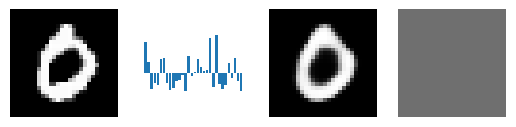

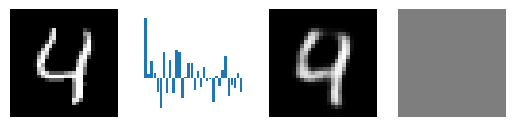

In [433]:
from likelihoods import GaussianLikelihood, BernoulliLikelihood

for image in test_images:
    with torch.no_grad():
        q, z, p = vae_model(image)
    if isinstance(vae_model.likelihood, GaussianLikelihood):
        reconstruction = image_view(p.loc.squeeze(0).squeeze(0), dataset_info[dataset_name]['image_dims'], dataset_info[dataset_name]['colour_channels'])
        uncertainty = image_view(p.scale.squeeze(0).squeeze(0), dataset_info[dataset_name]['image_dims'], dataset_info[dataset_name]['colour_channels'])
    elif isinstance(vae_model.likelihood, BernoulliLikelihood):
        reconstruction = image_view(p.probs.squeeze(0).squeeze(0), dataset_info[dataset_name]['image_dims'], dataset_info[dataset_name]['colour_channels'])
        uncertainty = image_view((p.probs * (1 - p.probs)).sqrt().squeeze(0).squeeze(0), dataset_info[dataset_name]['image_dims'], dataset_info[dataset_name]['colour_channels'])
    
    hetero = True
    ld = vae_model.latent_dim
    vmin = None
    vmax = None
    noise_cmap = "viridis"
    if isinstance(vae_model.likelihood, GaussianLikelihood):
        hetero = vae_model.likelihood.noise != 'homoscedastic'
        if vae_model.likelihood.noise.startswith('imagewise'):
            vmin = 0
            vmax = 0.25
            noise_cmap = "gray"  # darker = more confident
    
    fig, axes = plt.subplots(1, 3 + int(hetero))
    axes[0].imshow(image.squeeze(0).numpy(), cmap="gray")
    axes[0].axis(False)
    axes[1].bar([i for i in range(ld)], (0.15*ld*z.squeeze()).tolist())
    axes[1].axis(False)
    axes[1].invert_yaxis()
    axes[1].set_aspect('equal')
    axes[2].imshow(reconstruction.numpy(), cmap="gray")
    axes[2].axis(False)
    if hetero:
        axes[3].imshow(uncertainty.numpy(), cmap=noise_cmap, vmin=vmin, vmax=vmax)
        axes[3].axis(False)
    
    plt.show()
    

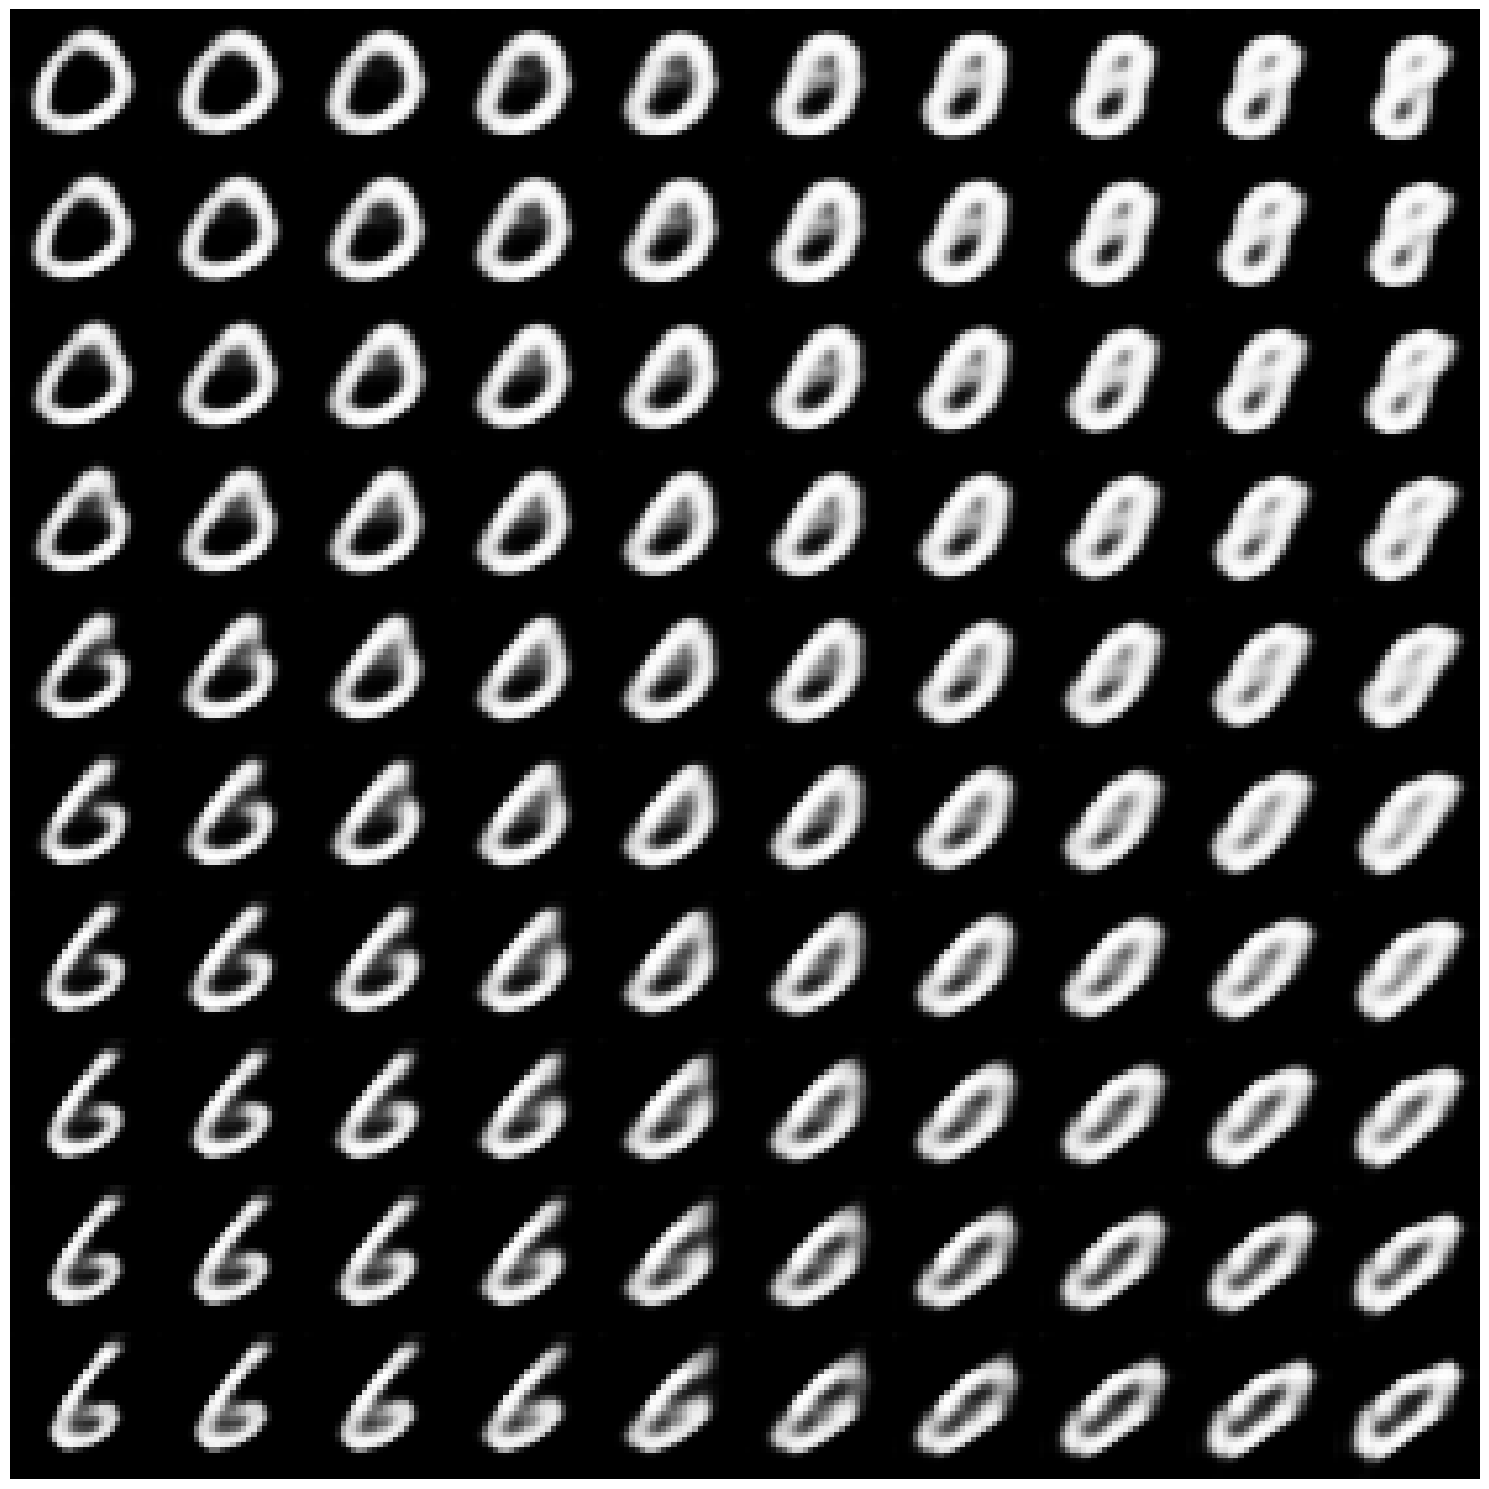

In [434]:
with torch.no_grad():
    _, z0, _ = vae_model(training_images[9].unsqueeze(0))
    _, z1, _ = vae_model(training_images[434].unsqueeze(0)) 
    _, z2, _ = vae_model(training_images[783].unsqueeze(0)) 
    _, z3, _ = vae_model(training_images[71].unsqueeze(0))  
    
n = 10
zs1 = torch.stack([z0*(i/(n-1)) + z1*(1-i/(n-1)) for i in range(n)])
zs2 = torch.stack([z2*(i/(n-1)) + z3*(1-i/(n-1)) for i in range(n)])

zs = torch.stack([zs1*(i/(n-1)) + zs2*(1-i/(n-1)) for i in range(n)])

fig, axes = plt.subplots(n, n, figsize=(15, 15))
for i in range(n):
    for j in range(n):
        with torch.no_grad():
            p_ij = vae_model.generate(zs[i, j])
            if isinstance(vae_model.likelihood, GaussianLikelihood):
                reconstruction = image_view(p_ij.loc.squeeze(0).squeeze(0), dataset_info[dataset_name]['image_dims'], dataset_info[dataset_name]['colour_channels'])
            elif isinstance(vae_model.likelihood, BernoulliLikelihood):
                reconstruction = image_view(p_ij.probs.squeeze(0).squeeze(0), dataset_info[dataset_name]['image_dims'], dataset_info[dataset_name]['colour_channels'])
        axes[i, j].imshow(reconstruction.numpy(), cmap="gray")
        axes[i, j].axis(False)
plt.tight_layout()
plt.subplots_adjust(hspace=0.0, wspace=0.0)
plt.show()


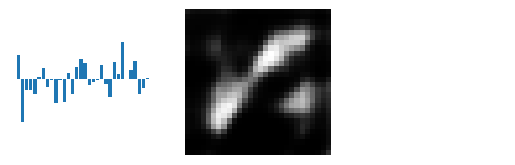

In [435]:
z_test = torch.randn(latent_dim)
with torch.no_grad():
    p = vae_model.generate(z_test)
if isinstance(vae_model.likelihood, GaussianLikelihood):
        reconstruction = image_view(p.loc.squeeze(0).squeeze(0), dataset_info[dataset_name]['image_dims'], dataset_info[dataset_name]['colour_channels'])
        uncertainty = image_view(p.scale.squeeze(0).squeeze(0), dataset_info[dataset_name]['image_dims'], dataset_info[dataset_name]['colour_channels'])
elif isinstance(vae_model.likelihood, BernoulliLikelihood):
        reconstruction = image_view(p.probs.squeeze(0).squeeze(0), dataset_info[dataset_name]['image_dims'], dataset_info[dataset_name]['colour_channels'])
        uncertainty = image_view((p.probs * (1 - p.probs)).sqrt().squeeze(0).squeeze(0), dataset_info[dataset_name]['image_dims'], dataset_info[dataset_name]['colour_channels'])

hetero = True
ld = vae_model.latent_dim
vmin = None
vmax = None
noise_cmap = "viridis"
if isinstance(vae_model.likelihood, GaussianLikelihood):
    hetero = vae_model.likelihood.noise != 'homoscedastic'
    if vae_model.likelihood.noise.startswith('imagewise'):
        vmin = 0
        vmax = 0.25
        noise_cmap = "gray"  # darker = more confident

fig, axes = plt.subplots(1, 2 + int(hetero))
axes[0].bar([i for i in range(latent_dim)], (0.15*ld*z_test.squeeze()).tolist())
axes[0].axis(False)
axes[0].set_aspect('equal')
axes[1].imshow(reconstruction.numpy(), cmap="gray")
axes[1].axis(False)
if hetero:
    axes[2].imshow(uncertainty.numpy(), cmap=noise_cmap, vmin=vmin, vmax=vmax)
    axes[2].axis(False)

plt.show()